# Imports and calibration file

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.pyplot as mpimg
import pickle
from moviepy.editor import VideoFileClip
from IPython.display import HTML

dist_pick = pickle.load( open( "./camera_cal/wide_dist_pickle.p", "rb" ) )

mtx = dist_pick["mtx"]
dst = dist_pick["dist"]

%matplotlib inline

# Calibration

In [2]:
# 9*6 boards
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calib*.jpg')
print("Calibration images found: " ,len(images))
# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (9,6), corners, ret)
        '''write_name = 'corners_found'+str(idx+1)+'.jpg'
        cv2.imwrite(write_name, img)'''
        cv2.imshow('img', img)
        cv2.waitKey(500)
    else:
        print("False image calib return: ", idx+1)

cv2.destroyAllWindows()

#calibrate the camera and write the files
'''img = cv2.imread('./camera_cal/calibration1.jpg')
img_size = (img.shape[1], img.shape[0])


ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "calibration.p", "wb" ) )'''

print("done")

Calibration images found:  20
False image calib return:  1
False image calib return:  15
False image calib return:  16
done


# Distortion Correction

True

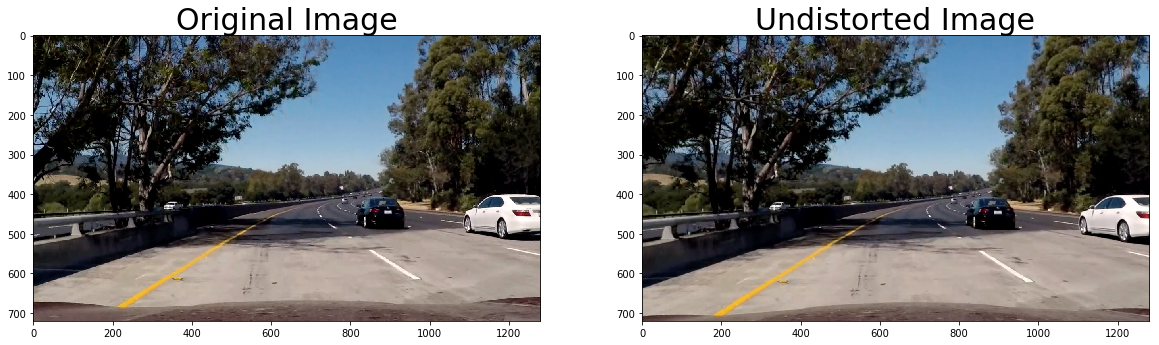

In [49]:
#example road image
test_img = mpimg.imread('./test_images/test5.jpg')
#example distorted checkboard image
test_check = mpimg.imread('./camera_cal/calibration1.jpg')

#undistort
test_undist = cv2.undistort(test_img, mtx, dst, None, mtx)
test_check = cv2.undistort(test_check, mtx, dst, None, mtx)

#write the example undistorted checkboard
cv2.imwrite('./camera_cal/test_undist.jpg',test_check)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(test_img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(test_undist)
ax2.set_title('Undistorted Image', fontsize=30)
cv2.imwrite('Distortion_correction.jpg',test_undist)

# Perspective Transform

(720, 1280, 3)


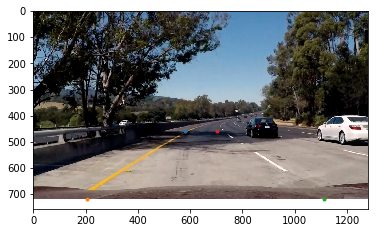

In [52]:
print(test_img.shape)
plt.imshow(test_img)
plt.plot(580, 460, '.') #tr
plt.plot(205, 720, '.') #br
plt.plot(1110, 720, '.') #bl
plt.plot(703, 460, '.') #tl
plt.figure()


# Warp the image to birds eye view

In [31]:
def warp(img):
    img_size = (img.shape[1], img.shape[0])
    w = img.shape[1]
    h = img.shape[0]
    #tr,br,bl,tl
    src = np.float32([(580, 460), (205, 720), (1110, 720), (703, 460)])
    dst = np.float32([(320, 0), (320, 720), (960, 720), (960, 0)])
    
    M = cv2.getPerspectiveTransform(src,dst)
    Minv = cv2.getPerspectiveTransform(dst,src)
    warped = cv2.warpPerspective(img,M,img_size,flags=cv2.INTER_LINEAR)
    return warped, Minv

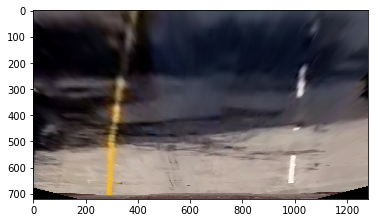

In [32]:
test_warp,Minv = warp(test_img)
plt.imshow(test_warp)


# Threshold Pipeline

the process below resembles the project one Pipeline 
The result is then passed through the sobel operator, targetting the derivative in X axis. The gradient threshold is taken based on the sobel X return, and the color threshold based on the output of the masking method. The thresholds are combined and the final binary image is an AND return of the thresholds where both binaries are 1.

The thresh hold used are derived from what we did in the class

In [33]:
def pipeline(img, s_thresh=(150,255), sx_thresh=(45,110)):
    img,minv = warp(img)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        
    #values to define color white boundaries in hsl
    lower_white = np.array([0,200,0], dtype = "uint8")
    upper_white = np.array([255,255,255], dtype = "uint8")

    #values to define yellow boundaries in hsl
    lower_yellow = np.array([10,0,100], dtype = "uint8")
    upper_yellow = np.array([40,200,255], dtype = "uint8")

    #create NumPy arrays from the boundaries and create the masks
    lowerW = np.array(lower_white, dtype = "uint8")
    upperW = np.array(upper_white, dtype = "uint8")
    mask_white = cv2.inRange(hls,lowerW,upperW)
    
    lowerY = np.array(lower_yellow, dtype = "uint8")
    upperY = np.array(upper_yellow, dtype = "uint8")
    mask_yellow = cv2.inRange(hls,lowerY,upperY)
    
    #bitwise OR the white and yellow masks
    mask = cv2.bitwise_or(mask_white,mask_yellow)
    
    #bitwise AND the grayscale image and the mask
    output = cv2.bitwise_and(gray,gray,mask=mask)
    
    # Sobel x
    sobelx = cv2.Sobel(output, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(output)
    s_binary[(output >= s_thresh[0]) & (output <= s_thresh[1])] = 1
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    color_binary = np.zeros_like(sxbinary)
    color_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    
    return color_binary, minv

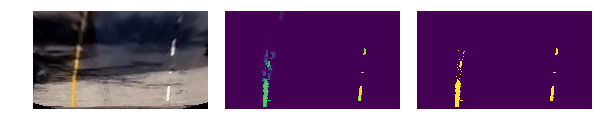

In [34]:
def show_masks(test_warp):
    img_pipe = test_warp
    gray = cv2.cvtColor(img_pipe, cv2.COLOR_RGB2GRAY)
    hls = cv2.cvtColor(img_pipe, cv2.COLOR_RGB2HLS)

    #values to define color white boundaries in hsl
    lower_white = np.array([0,200,0], dtype = "uint8")
    upper_white = np.array([255,255,255], dtype = "uint8")

    #values to define yellow boundaries in hsl
    lower_yellow = np.array([10,0,100], dtype = "uint8")
    upper_yellow = np.array([40,200,255], dtype = "uint8")

    #create NumPy arrays from the boundaries and create the masks
    lowerW = np.array(lower_white, dtype = "uint8")
    upperW = np.array(upper_white, dtype = "uint8")
    mask_white = cv2.inRange(hls,lowerW,upperW)

    lowerY = np.array(lower_yellow, dtype = "uint8")
    upperY = np.array(upper_yellow, dtype = "uint8")
    mask_yellow = cv2.inRange(hls,lowerY,upperY)

    #bitwise OR the white and yellow masks
    mask = cv2.bitwise_or(mask_white,mask_yellow)

    #bitwise AND the grayscale image and the mask
    test_output = cv2.bitwise_and(gray,gray,mask=mask)

    test_pipe, Minv = pipeline(test_img)
    return mask,test_output, test_pipe
mask,test_output, test_pipe = show_masks(test_warp)
fig, axs = plt.subplots(1,3, figsize=(10, 20))
fig.subplots_adjust(hspace = .2, wspace=.1)
axs = axs.ravel()
axs[0].imshow(test_warp)
axs[0].axis('off')
axs[1].imshow(test_output)
axs[1].axis('off')
axs[2].imshow(test_pipe)
axs[2].axis('off')
#just for testing
test_pipe, Minv2 = pipeline(test_img)

### Example pipeline results

done


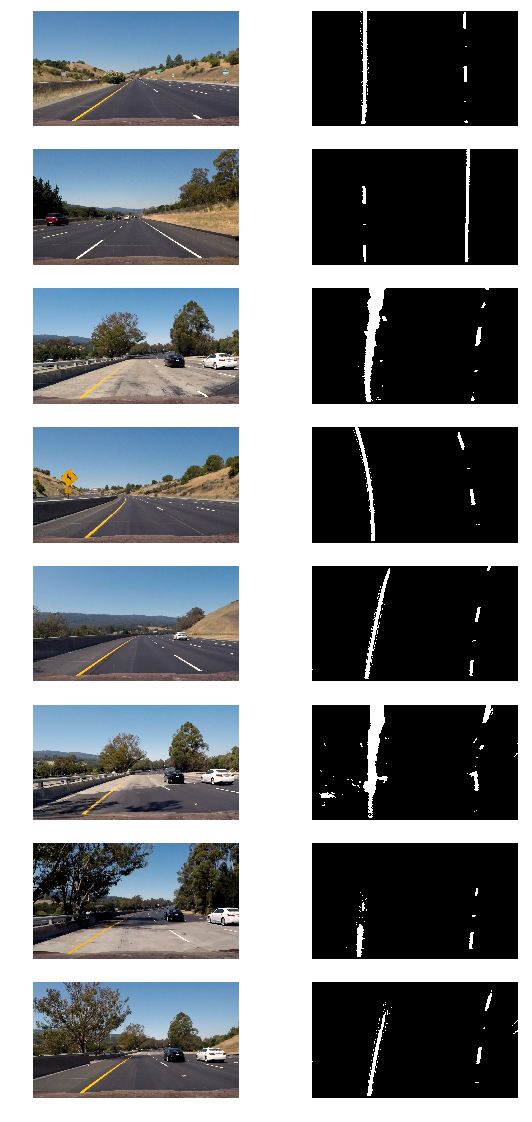

In [35]:
images = glob.glob('./test_images/*.jpg')
                                          
# Set up plot
fig, axs = plt.subplots(len(images),2, figsize=(10, 20))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()
                  
i = 0
for image in images:
    img = cv2.imread(image)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_bin, Minv = pipeline(img)
    axs[i].imshow(img)
    axs[i].axis('off')
    i += 1
    axs[i].imshow(img_bin, cmap='gray')
    axs[i].axis('off')
    i += 1

print("done")

# Sliding window function

In [36]:
def sliding_window(binary_warped):
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Take a histogram of the bottom half of the image
    #histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 10
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 85
    # Set minimum number of pixels found to recenter window
    minpix = 40
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 3) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 3) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    left_fit, right_fit = (None, None)
    # Fit a second order polynomial to each
    if len(leftx) != 0:
        left_fit = np.polyfit(lefty, leftx, 2)
    if len(rightx) != 0:
        right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting


    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    return out_img, left_fit, right_fit, left_lane_inds, right_lane_inds


### Example sliding window and histogram result

(720, 0)

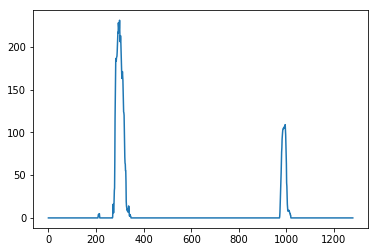

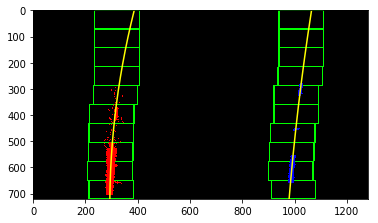

In [37]:
histogram = np.sum(test_pipe[test_pipe.shape[0]//2:,:], axis=0)
plt.plot(histogram)

def draw_sliding(out_img, left_fit, right_fit, left_lane_inds, right_lane_inds):
    
    plt.figure()
    # Generate x and y values for plotting
    ploty = np.linspace(0, test_pipe.shape[0]-1, test_pipe.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    nonzero = test_pipe.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    #plt.imshow(out_img)
    return out_img, left_fitx, right_fitx, ploty

out_img, left_fit, right_fit, left_lane_inds, right_lane_inds = sliding_window(test_pipe)

dsw_result, left_fitx, right_fitx, ploty = draw_sliding(out_img, left_fit, right_fit, left_lane_inds, right_lane_inds)
plt.imshow(dsw_result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

# Predict lanes function

This function is used to skip the sliding window process once it is know that lanes exist

In [38]:
def predict_lanes(binary_warped, left_fit, right_fit):
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 85
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit_new, right_fit_new = (None, None)
    if len(leftx) != 0:
        # Fit a second order polynomial to each
        left_fit_new = np.polyfit(lefty, leftx, 2)
    if len(rightx) != 0:
        right_fit_new = np.polyfit(righty, rightx, 2)
    
    return left_fit_new, right_fit_new, left_lane_inds, right_lane_inds


### Visualize output of predict lanes function

(720, 0)

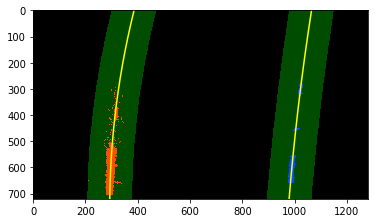

In [39]:
def draw_predict(left_fit, right_fit, left_fit2, right_fit2, left_lane_inds2, right_lane_inds2):
    margin = 85
    # Generate x and y values for plotting
    ploty = np.linspace(0, test_pipe.shape[0]-1, test_pipe.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    left_fitx2 = left_fit2[0]*ploty**2 + left_fit2[1]*ploty + left_fit2[2]
    right_fitx2 = right_fit2[0]*ploty**2 + right_fit2[1]*ploty + right_fit2[2]

    # Create an image to draw on and an image to show the selection window
    out_img = np.uint8(np.dstack((test_pipe, test_pipe, test_pipe))*255)
    window_img = np.zeros_like(out_img)

    # Color in left and right line pixels
    nonzero = test_pipe.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    out_img[nonzeroy[left_lane_inds2], nonzerox[left_lane_inds2]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds2], nonzerox[right_lane_inds2]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area (OLD FIT)
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    #plt.imshow(result)
    #plt.plot(left_fitx2, ploty, color='yellow')
    #plt.plot(right_fitx2, ploty, color='yellow')
    #plt.xlim(0, 1280)
    #plt.ylim(720, 0)
    return result, left_fitx2, right_fitx2, ploty

left_fit2, right_fit2, left_lane_inds2, right_lane_inds2 = predict_lanes(test_pipe, left_fit, right_fit)

dpl_result, left_fitx2, right_fitx2, ploty = draw_predict(left_fit, right_fit, left_fit2, right_fit2, left_lane_inds2, right_lane_inds2)
plt.imshow(dpl_result)
plt.plot(left_fitx2, ploty, color='yellow')
plt.plot(right_fitx2, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

# Calculate the curvature and distance from center

In [40]:
def calc_curv_rad_and_center_dist(bin_img, l_fit, r_fit, l_lane_inds, r_lane_inds):
    # Define conversions in x and y
    ym_per_pix = 30/720
    xm_per_pix = 3.7/700 
    left_curverad, right_curverad, center_dist = (0, 0, 0)
    # Define y-value where we want radius of curvature one less than height of image
    h = bin_img.shape[0]
    ploty = np.linspace(0, h-1, h)
    y_eval = np.max(ploty)
  
    #x and y positions of all nonzero pixels in the image
    nonzero = bin_img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    #Left and right line pixel positions
    leftx = nonzerox[l_lane_inds]
    lefty = nonzeroy[l_lane_inds] 
    rightx = nonzerox[r_lane_inds]
    righty = nonzeroy[r_lane_inds]
    
    if len(leftx) != 0 and len(rightx) != 0:
        # Fit new polynomials to x,y in world space
        left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
        right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
        # Calculate the new radii of curvature
        left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
        # Now our radius of curvature is in meters
    
    # Distance from center is image x midpoint - mean of l_fit and r_fit intercepts 
    if r_fit is not None and l_fit is not None:
        car_position = bin_img.shape[1]/2
        l_fit_x_int = l_fit[0]*h**2 + l_fit[1]*h + l_fit[2]
        r_fit_x_int = r_fit[0]*h**2 + r_fit[1]*h + r_fit[2]
        lane_center_position = (r_fit_x_int + l_fit_x_int) /2
        center_dist = (car_position - lane_center_position) * xm_per_pix
    return left_curverad, right_curverad, center_dist

### Example output of the curvature and distance

In [41]:
#rad_l, rad_r, d_center = calc_curv_rad_and_center_dist(warped_res, left_fit, right_fit, left_lane_inds, right_lane_inds)
rad_l, rad_r, d_center = calc_curv_rad_and_center_dist(test_pipe, left_fit, right_fit, left_lane_inds, right_lane_inds)

print('Radius of curvature for example:', rad_l, 'm,', rad_r, 'm')
print('Distance from lane center for example:', d_center, 'm')

Radius of curvature for example: 981.683535802 m, 3213.45748686 m
Distance from lane center for example: 0.0199526346027 m


# Draw the detected lanes over the image*

In [42]:
def draw_result(original_img, binary_img, l_fit, r_fit, Minv):
    new_img = np.copy(original_img)
    if l_fit is None or r_fit is None:
        return original_img
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    h,w = binary_img.shape
    ploty = np.linspace(0, h-1, num=h)# to cover same y-range as image
    left_fitx = l_fit[0]*ploty**2 + l_fit[1]*ploty + l_fit[2]
    right_fitx = r_fit[0]*ploty**2 + r_fit[1]*ploty + r_fit[2]

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,160, 255))
    cv2.polylines(color_warp, np.int32([pts_left]), isClosed=False, color=(255,0,0), thickness=25)
    cv2.polylines(color_warp, np.int32([pts_right]), isClosed=False, color=(0,255,0), thickness=25)

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (w, h)) 
    # Combine the result with the original image
    result = cv2.addWeighted(new_img, 1, newwarp, 0.5, 0)
    return result

### Example of drawn lanes

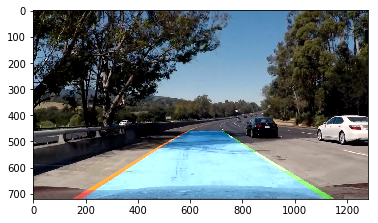

In [43]:
exampleImg_out1 = draw_result(test_img, test_pipe, left_fit, right_fit, Minv2)
plt.imshow(exampleImg_out1)

# Add curvature and distance data to image*

In [44]:
def draw_data(original_img, curv_rad, center_dist):
    new_img = np.copy(original_img)
    h = new_img.shape[0]
    font = cv2.FONT_HERSHEY_TRIPLEX
    text = 'Curve radius: ' + '{:00.2f}'.format(curv_rad) + 'm'
    cv2.putText(new_img, text, (40,70), font, 2.0, (0,0,0), 2, cv2.LINE_AA)
    text = '{:00.3f}'.format(center_dist) + 'm from the center'
    cv2.putText(new_img, text, (40,120), font, 2.0, (0,0,0), 2, cv2.LINE_AA)
    return new_img

### Example of added data

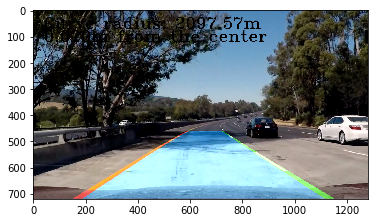

In [45]:
exampleImg_out2 = draw_data(exampleImg_out1, (rad_l+rad_r)/2, d_center)
plt.imshow(exampleImg_out2)

# Line class for tracking

In [46]:
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
    def add_fit(self, fit, inds):
        # add a found fit to the line, up to n
        if fit is not None:
            if self.best_fit is not None:
                # if we have a best fit, see how this new fit compares
                self.diffs = abs(fit-self.best_fit)
            if (self.diffs[0] > 0.001 or self.diffs[1] > 1.0 or self.diffs[2] > 100.) and len(self.current_fit) > 0:
                # bad fit! abort! abort! ... well, unless there are no fits in the current_fit queue, then we'll take it
                self.detected = False
            else:
                self.detected = True
                self.px_count = np.count_nonzero(inds)
                self.current_fit.append(fit)
                if len(self.current_fit) > 5:
                    # throw out old fits, keep newest n
                    self.current_fit = self.current_fit[len(self.current_fit)-5:]
                self.best_fit = np.average(self.current_fit, axis=0)
        # or remove one from the history, if not found
        else:
            self.detected = False
            if len(self.current_fit) > 0:
                # throw out oldest fit
                self.current_fit = self.current_fit[:len(self.current_fit)-1]
            if len(self.current_fit) > 0:
                # if there are still any fits in the queue, best_fit is their average
                self.best_fit = np.average(self.current_fit, axis=0)

## The full_pipeline function puts it all together

In [47]:
def full_pipeline(img):
    img = np.copy(img)
    imgUD = cv2.undistort(img, mtx, dst, None, mtx)
    pipeline_res, Minv = pipeline(imgUD)

    if not l_line.detected or not r_line.detected:
        sliding_res, left_fit, right_fit, left_lane_inds, right_lane_inds = sliding_window(pipeline_res)
    else:
        left_fit, right_fit, left_lane_inds, right_lane_inds = predict_lanes(pipeline_res, l_line.best_fit, r_line.best_fit)
    
    l_line.add_fit(left_fit, left_lane_inds)
    r_line.add_fit(right_fit, right_lane_inds)
    
    # draw the current best fit if it exists
    if l_line.best_fit is not None and r_line.best_fit is not None:
        draw_img = draw_result(imgUD,pipeline_res,left_fit,right_fit,Minv)
        left_crad, right_crad, cdistance = calc_curv_rad_and_center_dist(pipeline_res, left_fit, right_fit, left_lane_inds, right_lane_inds)
        final_res = draw_data(draw_img,(left_crad + right_crad)/2, cdistance)
    else:
        final_res = img          
    #left_crad, right_crad, cdistance = calc_curv_rad_and_center_dist(pipeline_res, left_fit, right_fit, left_lane_inds, right_lane_inds)
    #draw_img = draw_result(img,pipeline_res,left_fit,right_fit,Minv)

    #final_res = draw_data(draw_img,(left_crad + right_crad)/2, cdistance)
    test_warp,temp = warp(img)
    mask,test_output, test_pipe = show_masks(test_warp)
    
    # Calculate the size of screens
    result_screen_w = final_res.shape[1]
    result_screen_h = final_res.shape[0]
    diag_screen_w = np.int(result_screen_w / 3)
    diag_screen_h = np.int(result_screen_h / 3)
    screen_w = result_screen_w + diag_screen_w
    screen_h = result_screen_h
    # Assign result image to the screen
    screen = np.zeros((screen_h, screen_w, 3), dtype=np.uint8)
    screen[0:result_screen_h, 0:result_screen_w] = final_res
    
    # Assgin diagnosis image to the screen
    diag_img_1 = np.dstack((pipeline_res, pipeline_res, pipeline_res))*255
    screen[0:diag_screen_h, result_screen_w:, :] = cv2.resize(diag_img_1, (diag_screen_w, diag_screen_h))
    
    diag_img_2 = np.dstack((test_output, test_output, test_output))*255
    screen[diag_screen_h : diag_screen_h*2, result_screen_w:, :] = cv2.resize(diag_img_2, (diag_screen_w, diag_screen_h))
    
    diag_img_3 = test_warp
    screen[diag_screen_h*2 : diag_screen_h*3, result_screen_w:, :] = cv2.resize(diag_img_3, (diag_screen_w, diag_screen_h))
    
    return screen       
        
        

### One frame examples

done


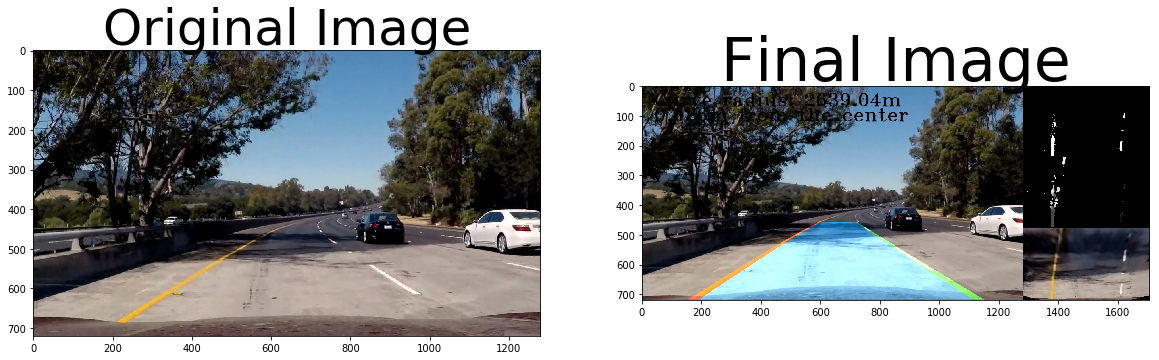

In [48]:
img = mpimg.imread('./test_images/test5.jpg')

l_line = Line()
r_line = Line()
test = full_pipeline(img)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(test)
ax2.set_title('Final Image', fontsize=60)
print("done")

In [27]:
l_line = Line()
r_line = Line()
video_output1 = 'project_video_output.mp4'
video_input1 = VideoFileClip('./project_video.mp4')
processed_video = video_input1.fl_image(full_pipeline)
%time processed_video.write_videofile(video_output1, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [02:51<00:00,  7.45it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

Wall time: 2min 52s
